### Current Pipeline 

In [7]:
import scanpy as sc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import spearmanr

In [8]:
# Load data31
j = 5
adata_12 = sc.read_h5ad("/data/dagyeman/cellranger/bam_file_analysis/1k_PBMCs/ub_objects/adata_matrices/adata_12.h5ad")  # Ground truth
adata_naive  = sc.read_h5ad(f"/data/dagyeman/cellranger/bam_file_analysis/1k_PBMCs/ub_objects/adata_matrices/adata_{j}.h5ad")   # Naive UMI-5
adata_pred = sc.read_h5ad(f"/data/dagyeman/cellranger/bam_file_analysis/1k_PBMCs/ub_objects/inv_nonunif_matrices/adata_{j}.h5ad")  # Predicted UMI-5


assert adata_12.obs_names.equals(adata_naive.obs_names), "Cell barcodes differ!"
assert adata_12.var_names.equals(adata_naive.var_names), "Genes differ!"


# adata_pred.X = np.round (adata_pred.X).astype(int)  # Convert predicted counts to integer

print(adata_naive.X)
print(adata_pred.X)
print("================")
print(np.linalg.norm(adata_12.X - adata_naive.X, ord='fro'))

print(np.linalg.norm(adata_12.X - adata_pred.X, ord='fro'))

print (np.linalg.norm(adata_naive.X - adata_pred.X, ord='fro'))

[[0. 0. 0. ... 2. 3. 1.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 3. ... 1. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 3.]
 [0. 0. 0. ... 1. 8. 0.]
 [0. 0. 0. ... 2. 0. 0.]]
[[0.         0.         0.         ... 2.00112367 3.00337334 1.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         3.00337334 ... 1.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.         0.         3.00337334]
 [0.         0.         0.         ... 1.         8.03159303 0.        ]
 [0.         0.         0.         ... 2.00112367 0.         0.        ]]
25803.756567600773
5624.1789434360335
21870.236137550233


#### Step 1: Load Labels and Preprocess Datasets 

In [9]:

# Load cell annotation labels (e.g., cell types)
labels = sc.read_h5ad("/data/dagyeman/cellranger/bam_file_analysis/1k_PBMCs/ub_objects/adata_matrices/cell_annotations/annotated_adata_matrices/annotated_adata_12.h5ad")
reference_labels = labels.obs['majority_voting'].copy()


gene = 'CD14_mono'
# Convert annotations: CD14_mono → CD14_mono, all others → Other cells
binary_labels = reference_labels.apply(lambda x: gene if x == gene else 'Other cells')
print(binary_labels)
# Assign binary labels to the datasets 

barcode
AAACCCAAGGAGAGTA-1      CD14_mono
AAACGCTTCAGCCCAG-1    Other cells
AAAGAACAGACGACTG-1    Other cells
AAAGAACCAATGGCAG-1    Other cells
AAAGAACGTCTGCAAT-1    Other cells
                         ...     
TTTCCTCTCTCTTGCG-1    Other cells
TTTGATCTCTTTGGAG-1    Other cells
TTTGGTTAGTAACCTC-1    Other cells
TTTGGTTGTAGAATAC-1      CD14_mono
TTTGTTGCAATTAGGA-1    Other cells
Name: majority_voting, Length: 1232, dtype: object


### Step 3: Normalization and Log

In [10]:
# BEFORE normalisation

### X-axis average counts and y-axis accuracy metric
    
adata_12.raw  = adata_12.copy()
adata_naive.raw = adata_naive.copy()
adata_pred.raw  = adata_pred.copy()

# sc.pp.highly_variable_genes(adata_12, n_top_genes=2000, flavor="seurat_v3")
sc.pp.normalize_total(adata_12, target_sum=1e4)
sc.pp.log1p(adata_12)  # Log-transform the data
adata_12.obs['label'] = binary_labels
print("This is the matrix for adata_12", adata_12.X)

# Repeat for naive and pred
# sc.pp.highly_variable_genes(adata_naive, n_top_genes=2000, flavor="seurat_v3")
sc.pp.normalize_total(adata_naive, target_sum=1e4)
sc.pp.log1p(adata_naive)  # Log-transform the data
adata_naive.obs['label'] = adata_12.obs['label'].loc[adata_naive.obs_names]
print("This is the matrix for adata_naive", adata_naive.X)

# sc.pp.highly_variable_genes(adata_pred, n_top_genes=2000, flavor="seurat_v3")
sc.pp.normalize_total(adata_pred, target_sum=1e4) 
sc.pp.log1p(adata_pred)  # Log-transform the data
adata_pred.obs['label'] = adata_12.obs['label'].loc[adata_pred.obs_names]
print("This is the matrix for adata_pred", adata_pred.X)

    
    
# print("This is the matrix for adata_12", adata_12.X)
# print("This is the matrix for adata_naive", adata_naive.X)
# print("This is the matrix for adata_pred", adata_pred.X)


This is the matrix for adata_12 [[0.         0.         0.         ... 0.91707144 1.17955576 0.5601735 ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         1.68582339 ... 0.90244774 0.         0.        ]
 ...
 [0.         0.         0.         ... 0.         0.         1.82676689]
 [0.         0.         0.         ... 0.50130374 1.82567404 0.        ]
 [0.         0.         0.         ... 1.30317499 0.         0.        ]]
This is the matrix for adata_naive [[0.         0.         0.         ... 0.92923343 1.1935741  0.56887764]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         1.69932847 ... 0.91231921 0.         0.        ]
 ...
 [0.         0.         0.         ... 0.         0.         1.6084786 ]
 [0.         0.         0.         ... 0.5076723  1.83917651 0.        ]
 [0.         0.         0.         ... 1.31441432 0.         0.        ]]
This is the matrix for adata_pred [[0.       

### Step 4: Run DE using t-test

- The following command compares gene expression between one cluster and all other clusters, across all genes, to find the most distinctly expressed genes

- For each gene and each cluster, scanpy computes log fold change, p-value, adj p-value, scores for ranking genes \n

- Tell you which genes are significanty more (or less) expressed in one cluster compared to the others

In [11]:
method = 'wilcoxon'  # Using t-test for differential expression analysis
sc.tl.rank_genes_groups(
    adata_12,
    groupby='label',
    method=method,
    key_added=method,
    use_raw=False
)
sc.tl.rank_genes_groups(
    adata_naive,
    groupby='label',
    method=method,
    key_added=method,
    use_raw=False
)
sc.tl.rank_genes_groups(
    adata_pred,
    groupby='label',
    method=method,
    key_added=method,
    use_raw=False
)

### Step 5: Extract DE results for one cluster

- extracting differential gene expression results for  specific cluster after running rank_gene_groups 
- The function below returns a pandas dataframe containing the ranked list of differentially expressed genes from a specific group clsuter
- group 1: You're pulling the DE genes where cluster "1" is compared against all the other clusters (one vs. rest)
- key = "t-test": You'res saying, "Give me the results from the DE analysis that used the t-test method
- de_12 = DE genes for cluster 1 using ground truth UMI-12 counts 
- de_5 = DE genes for cluster 1 using naive UMI-5 counts 
- de_5_pred: DE genes for cluster 1 usig predicited UMI-5 counts 

In [12]:
# gene = 'CD4.Naive'  # The gene of interest for differential expression analysis
de_12 = sc.get.rank_genes_groups_df(adata_12, group=gene, key=method)
de_naive = sc.get.rank_genes_groups_df(adata_naive, group=gene, key=method)
de_pred = sc.get.rank_genes_groups_df(adata_pred, group=gene, key=method)
print(de_12.head(10))
print("==================================")
print(de_naive.head(10))
print("==================================")
print(de_pred.head(10))
assert(len(de_12)) == len(de_naive) == len(de_pred), "Number of DE genes differ across datasets!"

    names     scores  logfoldchanges          pvals      pvals_adj
0  S100A8  24.376497        8.126340  3.036706e-131  8.571408e-127
1    FCN1  24.240925        6.652136  8.242455e-130  1.163258e-125
2    VCAN  24.172318        7.201283  4.350602e-129  4.093336e-125
3   CSF3R  24.151094        6.242465  7.271675e-129  5.131257e-125
4  S100A9  24.072783        7.948786  4.820402e-128  2.721213e-124
5     LYZ  23.927076        7.358271  1.601073e-126  7.531983e-123
6    MNDA  23.739271        6.015524  1.418197e-124  5.003754e-121
7  PLXDC2  23.455481        5.357612  1.162175e-121  2.982140e-118
8   LRMDA  23.421003        5.643537  2.611302e-121  6.142218e-118
9    CD36  23.336889        5.702466  1.872656e-120  4.065969e-117
    names     scores  logfoldchanges          pvals      pvals_adj
0  S100A8  24.377363        8.038355  2.973148e-131  8.392006e-127
1    FCN1  24.242485        6.641801  7.936199e-130  1.120036e-125
2    VCAN  24.166254        7.183455  5.038577e-129  4.740629e

In [13]:
import pandas as pd
import numpy as np
import scipy.sparse as sp


adata_gt = sc.read_h5ad("/data/dagyeman/cellranger/bam_file_analysis/1k_PBMCs/ub_objects/adata_matrices/adata_12.h5ad")  # Ground truth
# 1) Compute average counts per gene from adata_12
X12 = adata_gt.X
if sp.issparse(X12):
    avg12 = np.asarray(X12.mean(axis=0)).ravel()
else:
    avg12 = X12.mean(axis=0)

df_avg12 = pd.DataFrame({
    "gene": adata_gt.var_names,
    "avg_count": avg12
})

# 2) Merge into new DE DataFrames (preserving original de_* unmodified)
de_12_avg    = de_12   .merge(df_avg12, left_on="names", right_on="gene", how="left") \
                       .drop(columns="gene")
de_naive_avg = de_naive.merge(df_avg12, left_on="names", right_on="gene", how="left") \
                       .drop(columns="gene")
de_pred_avg  = de_pred .merge(df_avg12, left_on="names", right_on="gene", how="left") \
                       .drop(columns="gene")

# 3) Inspect
print("Ground truth DE + avg:\n",    de_12_avg   .head(), "\n")
print("Naive DE + avg:\n",           de_naive_avg.head(), "\n")
print("Predicted DE + avg:\n",       de_pred_avg .head(), "\n")
print(len(de_12_avg), len(de_naive_avg), len(de_pred_avg))


Ground truth DE + avg:
     names     scores  logfoldchanges          pvals      pvals_adj  avg_count
0  S100A8  24.376497        8.126340  3.036706e-131  8.571408e-127  38.176948
1    FCN1  24.240925        6.652136  8.242455e-130  1.163258e-125   6.495942
2    VCAN  24.172318        7.201283  4.350602e-129  4.093336e-125  10.063312
3   CSF3R  24.151094        6.242465  7.271675e-129  5.131257e-125   2.388799
4  S100A9  24.072783        7.948786  4.820402e-128  2.721213e-124  55.384740 

Naive DE + avg:
     names     scores  logfoldchanges          pvals      pvals_adj  avg_count
0  S100A8  24.377363        8.038355  2.973148e-131  8.392006e-127  38.176948
1    FCN1  24.242485        6.641801  7.936199e-130  1.120036e-125   6.495942
2    VCAN  24.166254        7.183455  5.038577e-129  4.740629e-125  10.063312
3   CSF3R  24.146589        6.232727  8.108827e-129  5.721993e-125   2.388799
4  S100A9  24.076941        7.819391  4.360471e-128  2.461573e-124  55.384740 

Predicted DE + avg:

In [14]:
gene_to_lookup = "MT-ND5"  # <-- replace with the gene you want

print("Ground truth DE + avg:\n", 
      de_12_avg.loc[de_12_avg['names'] == gene_to_lookup], "\n")

print("Naive DE + avg:\n", 
      de_naive_avg.loc[de_naive_avg['names'] == gene_to_lookup], "\n")

print("Predicted DE + avg:\n", 
      de_pred_avg.loc[de_pred_avg['names'] == gene_to_lookup], "\n")


Ground truth DE + avg:
         names    scores  logfoldchanges         pvals  pvals_adj  avg_count
27208  MT-ND5 -5.095643         0.00827  3.475596e-07   0.000004  19.261364 

Naive DE + avg:
         names    scores  logfoldchanges         pvals  pvals_adj  avg_count
27263  MT-ND5 -5.296877        0.005469  1.178001e-07   0.000001  19.261364 

Predicted DE + avg:
         names   scores  logfoldchanges         pvals  pvals_adj  avg_count
27239  MT-ND5 -5.18816        0.002716  2.123818e-07   0.000002  19.261364 



Total |log₂(lfc_12/lfc_naive) U[5]| = 0.082
Total |log₂(lfc_12/lfc_pred) U[5]| = 0.004


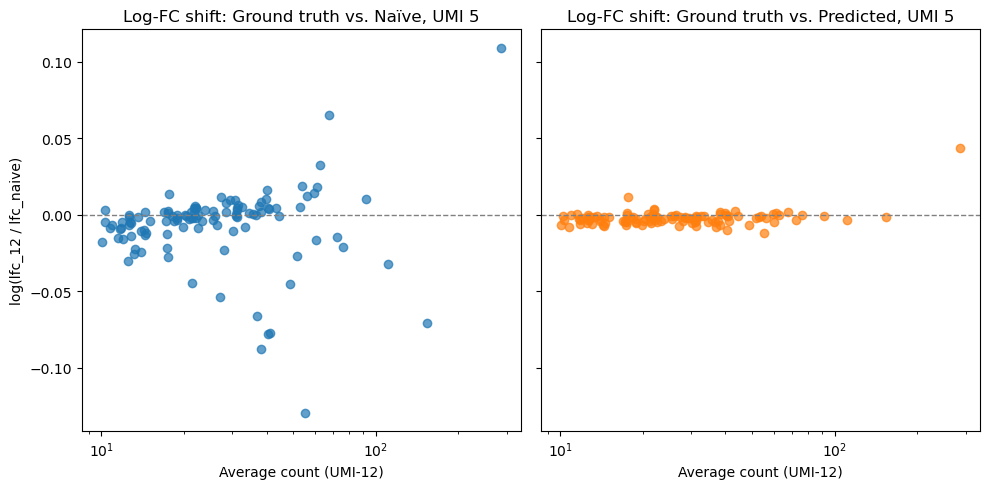

In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ---- Filter genes based on de_12_avg criteria ----
fc_hi = 0.32
fc_lo = -0.32

# Pick p-value column robustly
pcol = 'pvals_adj' if 'pvals_adj' in de_12_avg.columns else 'pvals'

keep_genes = de_12_avg.loc[
    ((de_12_avg['logfoldchanges'] >= fc_hi) | (de_12_avg['logfoldchanges'] <= fc_lo))
    & (de_12_avg[pcol] < 0.05)
    & (de_12_avg['avg_count'] >= 10),
    'names'
]

# Restrict all three to the same gene set (from UMI-12 filter)
de_12_avg    = de_12_avg[de_12_avg['names'].isin(keep_genes)]
de_naive_avg = de_naive_avg[de_naive_avg['names'].isin(keep_genes)]
de_pred_avg  = de_pred_avg[de_pred_avg['names'].isin(keep_genes)]
# ---- end filter block ----



# 1) Merge all three into a single DataFrame using logfoldchanges
df = (
    de_12_avg[['names','logfoldchanges','avg_count']]
      .rename(columns={'logfoldchanges':'lfc_12'})
      .merge(
          de_naive_avg[['names','logfoldchanges']]
            .rename(columns={'logfoldchanges':'lfc_naive'}),
          on='names'
      )
      .merge(
          de_pred_avg[['names','logfoldchanges']]
            .rename(columns={'logfoldchanges':'lfc_pred'}),
          on='names'
      )
)

# 2) Sort by average count
df = df.sort_values('avg_count').reset_index(drop=True)



df["logrf_naive"] = ((df['lfc_naive'])  - (df['lfc_12']))
df["logrf_pred"]  = ((df['lfc_pred'])  - (df['lfc_12'] ))



sum_squared_naive = (df['logrf_naive'] ** 2).sum()
sum_squared_pred = (df['logrf_pred']  ** 2).sum()




print(f"Total |log₂(lfc_12/lfc_naive) U[{j}]| = {sum_squared_naive:.3f}")
print(f"Total |log₂(lfc_12/lfc_pred) U[{j}]| = {sum_squared_pred:.3f}")

# 4) Plot
fig, axes = plt.subplots(1, 2, figsize=(10, 5), sharey=True)

# Subplot 1: ground‐truth vs naive (fold‐change ratio)
axes[0].scatter(df['avg_count'], df['logrf_naive'], alpha=0.7)
axes[0].axhline(0, color='grey', linestyle='--', linewidth=1)
axes[0].set_xlabel('Average count (UMI-12)')
axes[0].set_ylabel('log(lfc_12 / lfc_naive)')
axes[0].set_xscale('log')
axes[0].set_title(f'Log‐FC shift: Ground truth vs. Naïve, UMI {j}')

# Subplot 2: ground‐truth vs predicted
axes[1].scatter(df['avg_count'], df['logrf_pred'], alpha=0.7, color='C1')
axes[1].axhline(0, color='grey', linestyle='--', linewidth=1)
axes[1].set_xlabel('Average count (UMI-12)')
axes[1].set_xscale('log')
axes[1].set_title(f'Log‐FC shift: Ground truth vs. Predicted, UMI {j}')

plt.tight_layout()
plt.show()




In [16]:
# Find the gene with the highest logrf_pred value
max_pred_idx = df['logrf_pred'].idxmax()
max_pred_gene = df.loc[max_pred_idx, 'names']
max_pred_value = df.loc[max_pred_idx, 'logrf_pred']

print(f"Gene with highest logrf_pred: {max_pred_gene} ({max_pred_value:.4f})")


Gene with highest logrf_pred: MALAT1 (0.0434)


## Stuff for saving 

### All genes

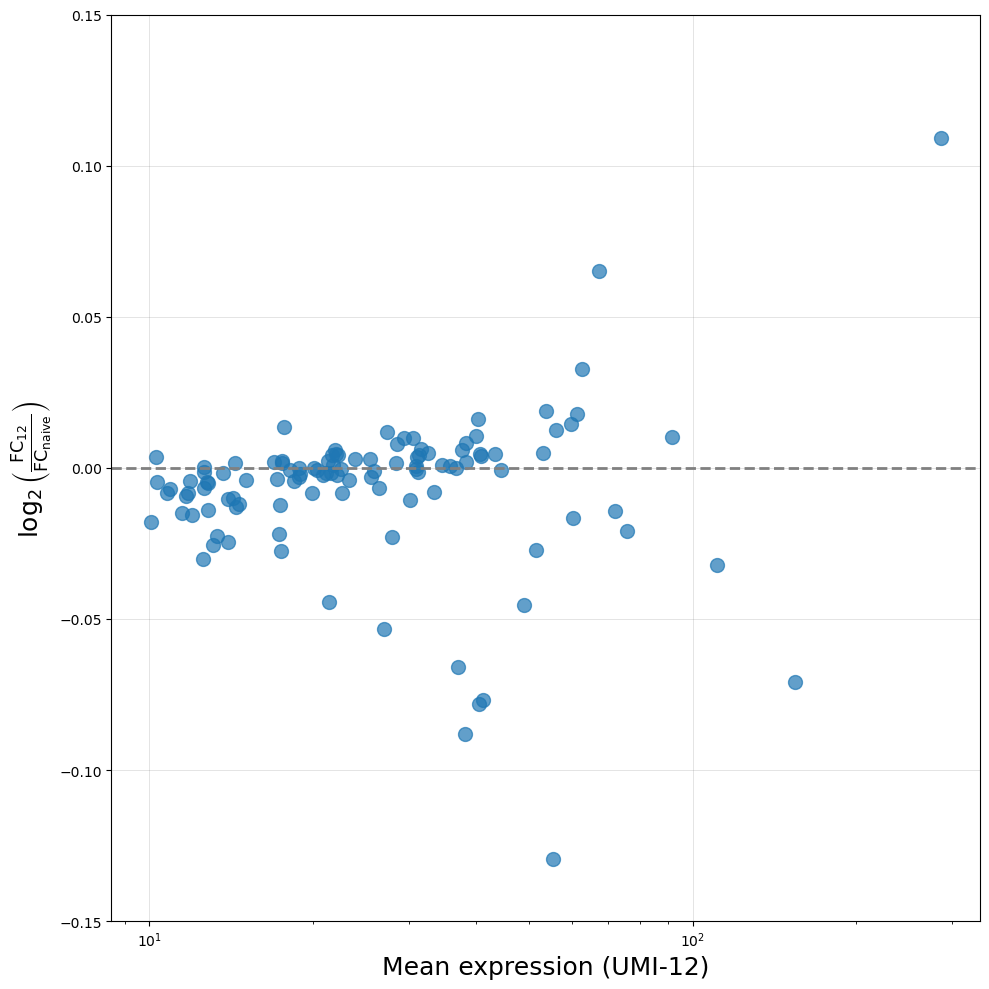

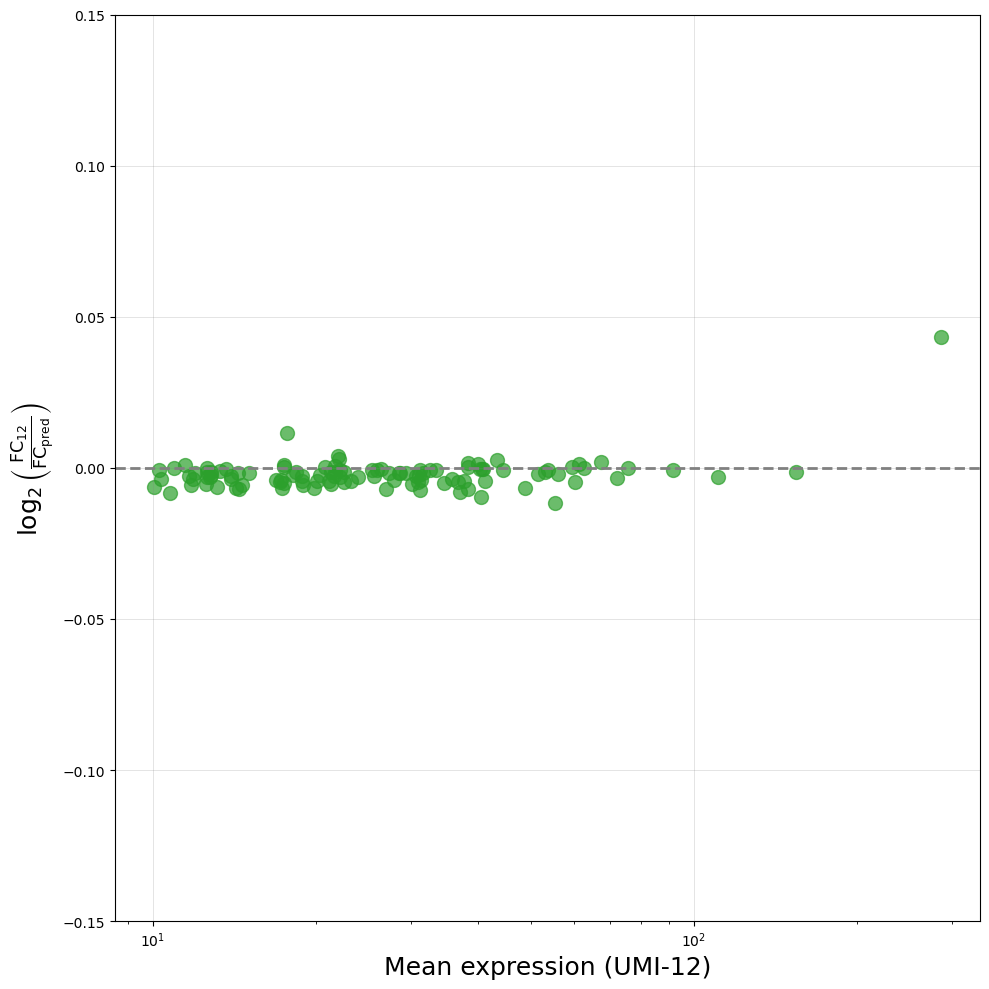

In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ---- Filter genes based on de_12_avg criteria ----
fc_hi = np.log2(1.25)  # approx 0.32
fc_lo = -np.log2(1.25) # approx -0.32
pval_threshold = 0.05
gene_filter= 10
pcol = 'pvals_adj' if 'pvals_adj' in de_12_avg.columns else 'pvals'

keep_genes = de_12_avg.loc[
    ((de_12_avg['logfoldchanges'] >= fc_hi) | (de_12_avg['logfoldchanges'] <= fc_lo))
    & (de_12_avg[pcol] < pval_threshold)
    & (de_12_avg['avg_count'] >= gene_filter),
    'names'
]

# Restrict all three to the same gene set
de_12_avg    = de_12_avg[de_12_avg['names'].isin(keep_genes)]
de_naive_avg = de_naive_avg[de_naive_avg['names'].isin(keep_genes)]
de_pred_avg  = de_pred_avg[de_pred_avg['names'].isin(keep_genes)]

# ---- Merge into DataFrame ----
df = (
    de_12_avg[['names','logfoldchanges','avg_count']]
      .rename(columns={'logfoldchanges':'lfc_12'})
      .merge(
          de_naive_avg[['names','logfoldchanges']]
            .rename(columns={'logfoldchanges':'lfc_naive'}),
          on='names'
      )
      .merge(
          de_pred_avg[['names','logfoldchanges']]
            .rename(columns={'logfoldchanges':'lfc_pred'}),
          on='names'
      )
)

# ---- Sort by average count ----
df = df.sort_values('avg_count').reset_index(drop=True)


# df['logrf_naive'] = np.log2(df['lfc_12'] / df['lfc_naive'])
# df['logrf_pred']  = np.log2(df['lfc_12'] / df['lfc_pred'])

df["logrf_naive"] = ((df['lfc_naive'])  - (df['lfc_12']))
df["logrf_pred"]  = ((df['lfc_pred'])  - (df['lfc_12'] ))

# sum_abs_naive = df['logrf_naive'].abs().sum()
# sum_abs_pred  = df['logrf_pred'].abs().sum()
# print(f"Total |log₂(lfc_12/lfc_naive) U[{j}]| = {sum_abs_naive:.3f}")
# print(f"Total |log₂(lfc_12/lfc_pred) U[{j}]| = {sum_abs_pred:.3f}")

sum_squared_naive = (df['logrf_naive'] ** 2).sum()
sum_squared_pred = (df['logrf_pred']  ** 2).sum()

# print(f"Mean squared error naive U[{j}]|") {sum_squared_naive / len(df)
# print(f"Mean squared error pred U[{j}]|") sum_squared_pred / len(df)



# ---- Plot 1: Ground‐truth vs Naive ----
plt.figure(figsize=(10, 10))
plt.scatter(df['avg_count'], df['logrf_naive'], alpha=0.7,color = '#1f77b4', s=100)
plt.axhline(0, color='grey', linestyle='--', linewidth=2)
plt.xscale('log')
plt.xlabel('Mean expression (UMI-12)', fontsize=18)
plt.ylabel(r"$\log_2\left(\frac{\mathrm{FC}_{12}}{\mathrm{FC}_{\mathrm{naive}}}\right)$", fontsize=18)
plt.ylim(-0.15, 0.15)
# plt.title(f'Log‐FC shift: Ground truth vs. Naïve, UMI {j}', fontsize=18)
plt.grid(True, which='major', linestyle='-', linewidth=0.5, color='gray', alpha=0.3)

plt.tight_layout()
plt.savefig(f"/data/dagyeman/cellranger/bam_file_analysis/paper_figures/logfc_naive_UMI_{j}.pdf")
plt.show()

# ---- Plot 2: Ground‐truth vs Predicted ----
plt.figure(figsize=(10, 10))
plt.scatter(df['avg_count'], df['logrf_pred'], alpha=0.7, color='#2ca02c', s=100)
plt.axhline(0, color='grey', linestyle='--', linewidth=2)
plt.xscale('log')
plt.xlabel('Mean expression (UMI-12)', fontsize=18)
plt.ylabel(r"$\log_2\left(\frac{\mathrm{FC}_{12}}{\mathrm{FC}_{\mathrm{pred}}}\right)$", fontsize=18)
plt.ylim(-0.15, 0.15)
plt.grid(True, which='major', linestyle='-', linewidth=0.5, color='gray', alpha=0.3)
# plt.title(f'Log‐FC shift: Ground truth vs. Predicted, UMI {j}', fontsize=18)
plt.tight_layout()
plt.savefig(f"/data/dagyeman/cellranger/bam_file_analysis/paper_figures/logfc_pred_UMI_{j}.pdf")
plt.show()



In [223]:
# import numpy as np
# import pandas as pd
# import matplotlib.pyplot as plt

# # ---- Filter genes based on de_12_avg criteria ----
# fc_hi = np.log2(1.25)  # approx 0.32
# fc_lo = -np.log2(1.25) # approx -0.32
# pval_threshold = 0.05
# gene_filter= 10
# pcol = 'pvals_adj' if 'pvals_adj' in de_12_avg.columns else 'pvals'

# keep_genes = de_12_avg.loc[
#     ((de_12_avg['logfoldchanges'] >= fc_hi) | (de_12_avg['logfoldchanges'] <= fc_lo))
#     & (de_12_avg[pcol] < pval_threshold)
#     & (de_12_avg['avg_count'] >= gene_filter),
#     'names'
# ]

# # Restrict all three to the same gene set
# de_12_avg    = de_12_avg[de_12_avg['names'].isin(keep_genes)]
# de_naive_avg = de_naive_avg[de_naive_avg['names'].isin(keep_genes)]
# de_pred_avg  = de_pred_avg[de_pred_avg['names'].isin(keep_genes)]

# # ---- Merge into DataFrame ----
# df = (
#     de_12_avg[['names','logfoldchanges','avg_count']]
#       .rename(columns={'logfoldchanges':'lfc_12'})
#       .merge(
#           de_naive_avg[['names','logfoldchanges']]
#             .rename(columns={'logfoldchanges':'lfc_naive'}),
#           on='names'
#       )
#       .merge(
#           de_pred_avg[['names','logfoldchanges']]
#             .rename(columns={'logfoldchanges':'lfc_pred'}),
#           on='names'
#       )
# )

# # ---- Sort by average count ----
# df = df.sort_values('avg_count').reset_index(drop=True)


# df['logrf_naive'] = np.log2(df['lfc_12'] / df['lfc_naive'])
# df['logrf_pred']  = np.log2(df['lfc_12'] / df['lfc_pred'])

# sum_abs_naive = df['logrf_naive'].abs().sum()
# sum_abs_pred  = df['logrf_pred'].abs().sum()
# print(f"Total |log₂(lfc_12/lfc_naive) U[{j}]| = {sum_abs_naive:.3f}")
# print(f"Total |log₂(lfc_12/lfc_pred) U[{j}]| = {sum_abs_pred:.3f}")

# # ---- Plot 1: Ground‐truth vs Naive ----
# plt.figure(figsize=(10, 10))
# plt.scatter(df['avg_count'], df['logrf_naive'], alpha=0.7,color = '#1f77b4', s=100)
# plt.axhline(0, color='grey', linestyle='--', linewidth=2)
# plt.xscale('log')
# plt.xlabel('Mean expression (UMI-12)', fontsize=18)
# plt.ylabel(r"$\log_2\left(\frac{\mathrm{LFC}_{12}}{\mathrm{LFC}_{\mathrm{naive}}}\right)$", fontsize=18)
# plt.ylim(-0.10, 0.15)
# # plt.title(f'Log‐FC shift: Ground truth vs. Naïve, UMI {j}', fontsize=18)
# plt.tight_layout()
# plt.savefig(f"/data/dagyeman/cellranger/bam_file_analysis/paper_figures/logfc_naive_UMI_{j}.pdf")
# plt.show()

# # ---- Plot 2: Ground‐truth vs Predicted ----
# plt.figure(figsize=(10, 10))
# plt.scatter(df['avg_count'], df['logrf_pred'], alpha=0.7, color='#2ca02c', s=100)
# plt.axhline(0, color='grey', linestyle='--', linewidth=2)
# plt.xscale('log')
# plt.xlabel('Mean expression (UMI-12)', fontsize=18)
# plt.ylabel(r"$\log_2\left(\frac{\mathrm{LFC}_{12}}{\mathrm{LFC}_{\mathrm{pred}}}\right)$", fontsize=18)
# plt.ylim(-0.10, 0.15)
# # plt.title(f'Log‐FC shift: Ground truth vs. Predicted, UMI {j}', fontsize=18)
# plt.tight_layout()
# plt.savefig(f"/data/dagyeman/cellranger/bam_file_analysis/paper_figures/logfc_pred_UMI_{j}.pdf")
# plt.show()


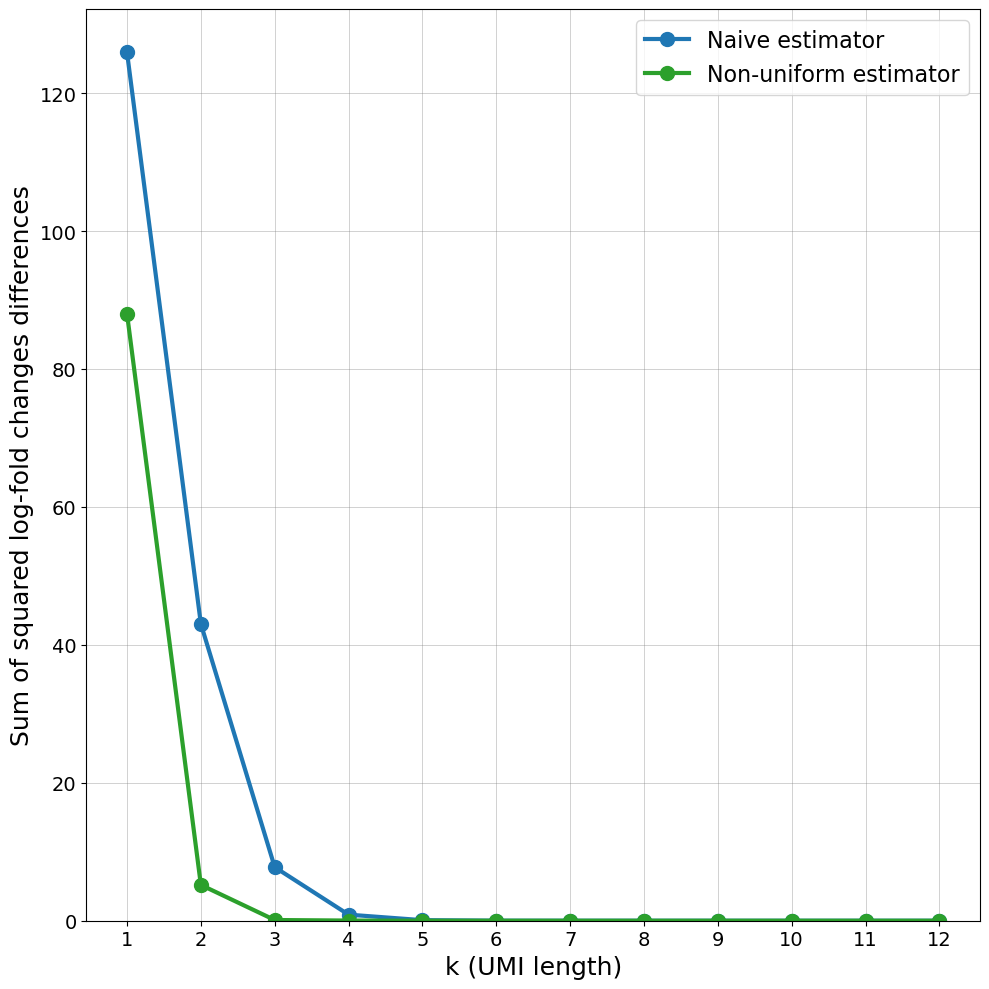

In [24]:
import matplotlib.pyplot as plt
import numpy as np

# UMI lengths 1 through 12
k = np.arange(1, 13)

# New totals (SSE values)
loss_sse_naive = np.array([
    125.904434, 43.035454, 7.764187, 0.878885,
    0.082176, 0.008276, 0.001060, 0.000340,
    0.000285, 0.000161, 0.000041, 0.000000
])

loss_sse_pred = np.array([
    88.003983, 5.187624, 0.103573, 0.023881,
    0.003628, 0.000924, 0.000376, 0.000273,
    0.000279, 0.000160, 0.000041, 0.000000
])

plt.figure(figsize=(10, 10))
plt.plot(k, loss_sse_naive, marker='o', markersize=10, linewidth=3,
         label='Naive estimator', color='#1f77b4')
plt.plot(k, loss_sse_pred, marker='o', markersize=10, linewidth=3,
         label='Non-uniform estimator', color='#2ca02c')

plt.xticks(k, fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('k (UMI length)', fontsize=18)
plt.ylabel('Sum of squared log-fold changes differences', fontsize=18)
# plt.title('SSE vs. UMI length', fontsize=18)
plt.grid(True, linestyle='-', linewidth=0.5, color='gray', alpha=0.5)
plt.legend(fontsize=16)
plt.tight_layout()
plt.ylim(0)
plt.savefig("/data/dagyeman/cellranger/bam_file_analysis/paper_figures/cumulative_plot_sse_total.pdf")
plt.show()

